In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e2/sample_submission.csv
/kaggle/input/playground-series-s5e2/train.csv
/kaggle/input/playground-series-s5e2/test.csv
/kaggle/input/playground-series-s5e2/training_extra.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e2/train.csv')
train_df = train_df.drop('id', axis =1)
train_df.head()


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [3]:
#describe the dataset to get a cursory look at the data
train_df.describe()


,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [4]:
#descriptions for the categorical values in the dataset
train_df.describe(exclude = np.number)

,Brand,Material,Size,Laptop Compartment,Waterproof,Style,Color
count,290295,291653,293405,292556,292950,292030,290050
unique,5,4,3,2,2,3,6
top,Adidas,Polyester,Medium,Yes,Yes,Messenger,Pink
freq,60077,79630,101906,148342,148077,100031,51690


In [5]:
features = np.array(train_df.columns[:-1])
print(f'The features are: \n'
        f'{features}')

The features are: 
['Brand' 'Material' 'Size' 'Compartments' 'Laptop Compartment'
 'Waterproof' 'Style' 'Color' 'Weight Capacity (kg)']


In [6]:
#We see that some features do not have quantitative values but instead
#have categorical values like whether it has a laptop bag or not, 
#whether the bag is waterproof or not and what size the bag is.
#Let's check how many distinct values exist for these features

distinct_style = train_df['Style'].unique()
print(distinct_style) # Output: ['Tote' 'Messenger' nan 'Backpack']

distinct_sizes = train_df['Size'].unique()
print(distinct_sizes)

['Tote' 'Messenger' nan 'Backpack']
['Medium' 'Small' 'Large' nan]


In [7]:
#isolate the data matrix
X = train_df[features]
#print(X)
print(X.shape)

#isolate the target variables
y = train_df['Price']
y = np.reshape(y, (len(y),1))
#print(y)
print(y.shape)

print(X.dtypes)

(300000, 9)
(300000, 1)
Brand                    object
Material                 object
Size                     object
Compartments            float64
Laptop Compartment       object
Waterproof               object
Style                    object
Color                    object
Weight Capacity (kg)    float64
dtype: object


In [8]:
# Extract text features
cats = X.select_dtypes(exclude=np.number).columns.tolist()
print(cats)

# Convert to Pandas category for xgboost to deal with
for col in cats:
   X[col] = X[col].astype('category')

print(X.dtypes)

['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
Brand                   category
Material                category
Size                    category
Compartments             float64
Laptop Compartment      category
Waterproof              category
Style                   category
Color                   category
Weight Capacity (kg)     float64
dtype: object


<ipython-input-8-15e0251dc8fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-8-15e0251dc8fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')
<ipython-input-8-15e0251dc8fb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

In [9]:
#Let's try to run a quick boosted decision tree model
#we implement this because the xgboost model can handle the
#categorical values and enables us to get results without
#encoding the categorical values

from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

import xgboost as xgb

# Create regression matrices
btrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
btest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)


In [10]:
## Training

# Define hyperparameters
params = {"objective": "reg:squarederror",
          "tree_method": "hist", 
          'device': 'cuda',
         "max_depth": 6,                   # Maximum depth of a tree
        "learning_rate": 0.1,             # Step size shrinkage
        "gamma": 0,                       # Minimum loss reduction required to make a further partition on a leaf node of the tree
        "subsample": 0.8,                 # Subsample ratio of the training instances
        "colsample_bytree": 0.8,          # Subsample ratio of columns when constructing each tree
        "nthread": 4}                     # Number of parallel threads used to run XGBoost
   
evals = [(btrain_reg, "train"), (btest_reg, "validation")]
n = 100

#create the xgboost model
model = xgb.train(
   params=params, #what are the hyperparameters involved?
   dtrain=btrain_reg, #what's the training data? (Regression Matrices)
   num_boost_round=n, #maximum rounds to train
    evals=evals, #evals to be done
    verbose_eval=5, #after every 5 rounds
    early_stopping_rounds=10, # Stop if validation metric does not improve for 10 rounds
)



[0]	train-rmse:39.02440	validation-rmse:39.05516
[5]	train-rmse:38.98817	validation-rmse:39.03805
[10]	train-rmse:38.96272	validation-rmse:39.03372
[15]	train-rmse:38.93775	validation-rmse:39.02903
[20]	train-rmse:38.91723	validation-rmse:39.02983
[25]	train-rmse:38.89752	validation-rmse:39.02828
[30]	train-rmse:38.87765	validation-rmse:39.02797
[35]	train-rmse:38.85812	validation-rmse:39.02883
[39]	train-rmse:38.84261	validation-rmse:39.03221


In [11]:
model

Feature importance by weight:
{'Brand': 316.0, 'Material': 223.0, 'Size': 204.0, 'Compartments': 345.0, 'Laptop Compartment': 120.0, 'Waterproof': 128.0, 'Style': 215.0, 'Color': 341.0, 'Weight Capacity (kg)': 672.0}


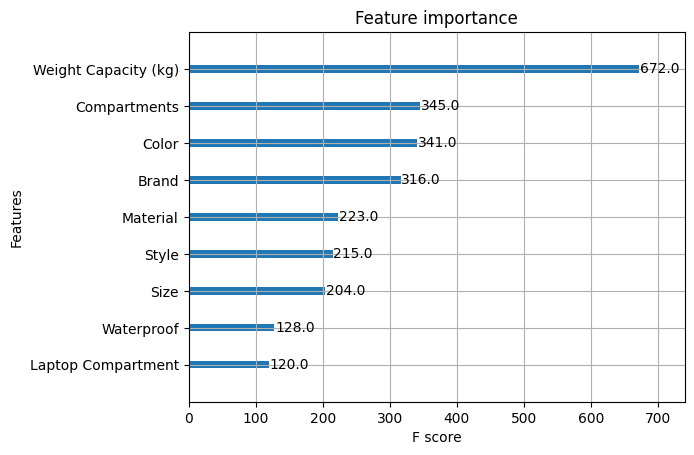

In [12]:
# Get feature importance
importance = model.get_score(importance_type='weight')
print("Feature importance by weight:")
print(importance)

# Plot feature importance
import matplotlib.pyplot as plt
xgb.plot_importance(model)
plt.show()

In [13]:
## Testing

from sklearn.metrics import mean_squared_error

preds = model.predict(btest_reg)


rmse = mean_squared_error(y_test, preds, squared=False)

print(f"RMSE of the base model: {rmse:.3f}")



RMSE of the base model: 39.033


In [14]:
print(preds)
print(y_test)

[84.04274  79.95741  81.224884 ... 80.98525  85.461365 80.98911 ]
[[ 31.78088]
 [150.     ]
 [144.69007]
 ...
 [ 82.56549]
 [ 27.40082]
 [148.89493]]
